---
### Naval Propulsion Data Analysis
---
Data source: http://archive.ics.uci.edu/ml/datasets/condition+based+maintenance+of+naval+propulsion+plants

In [1]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns 
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
sns.set()

---
#### Import and Inspect Data
---

In [2]:
data = pd.read_csv(r'data.txt', delimiter = '   ', engine = 'python', header = None)
headers = pd.read_csv(r'Features.txt', header = None)

data.columns = [i.split(' - ')[1] for i in headers.iloc[:,0]]

data.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11934 entries, 0 to 11933
Data columns (total 18 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   Lever position (lp) [ ]                        11934 non-null  float64
 1   Ship speed (v) [knots]                         11934 non-null  float64
 2   Gas Turbine shaft torque (GTT) [kN m]          11934 non-null  float64
 3   Gas Turbine rate of revolutions (GTn) [rpm]    11934 non-null  float64
 4   Gas Generator rate of revolutions (GGn) [rpm]  11934 non-null  float64
 5   Starboard Propeller Torque (Ts) [kN]           11934 non-null  float64
 6   Port Propeller Torque (Tp) [kN]                11934 non-null  float64
 7   HP Turbine exit temperature (T48) [C]          11934 non-null  float64
 8   GT Compressor inlet air temperature (T1) [C]   11934 non-null  float64
 9   GT Compressor outlet air temperature (T2) [C]  119

In [3]:
data.describe()

,Lever position (lp) [ ],Ship speed (v) [knots],Gas Turbine shaft torque (GTT) [kN m],Gas Turbine rate of revolutions (GTn) [rpm],Gas Generator rate of revolutions (GGn) [rpm],Starboard Propeller Torque (Ts) [kN],Port Propeller Torque (Tp) [kN],HP Turbine exit temperature (T48) [C],GT Compressor inlet air temperature (T1) [C],GT Compressor outlet air temperature (T2) [C],HP Turbine exit pressure (P48) [bar],GT Compressor inlet air pressure (P1) [bar],GT Compressor outlet air pressure (P2) [bar],Gas Turbine exhaust gas pressure (Pexh) [bar],Turbine Injecton Control (TIC) [%],Fuel flow (mf) [kg/s],GT Compressor decay state coefficient.,GT Turbine decay state coefficient.
count,11934.000000,11934.000000,11934.000000,11934.000000,11934.000000,11934.000000,11934.000000,11934.000000,11934.0,11934.000000,11934.000000,1.193400e+04,11934.000000,11934.000000,11934.000000,11934.000000,11934.00000,11934.0000
mean,5.166667,15.000000,27247.498685,2136.289256,8200.947312,227.335768,227.335768,735.495446,288.0,646.215331,2.352963,9.980000e-01,12.297123,1.029474,33.641261,0.662440,0.97500,0.9875
std,2.626388,7.746291,22148.613155,774.083881,1091.315507,200.495889,200.495889,173.680552,0.0,72.675882,1.084770,2.220539e-16,5.337448,0.010390,25.841363,0.507132,0.01472,0.0075
min,1.138000,3.000000,253.547000,1307.675000,6589.002000,5.304000,5.304000,442.364000,288.0,540.442000,1.093000,9.980000e-01,5.828000,1.019000,0.000000,0.068000,0.95000,0.9750
25%,3.144000,9.000000,8375.883750,1386.758000,7058.324000,60.317000,60.317000,589.872750,288.0,578.092250,1.389000,9.980000e-01,7.447250,1.020000,13.677500,0.246000,0.96200,0.9810
50%,5.140000,15.000000,21630.659000,1924.326000,8482.081500,175.268000,175.268000,706.038000,288.0,637.141500,2.083000,9.980000e-01,11.092000,1.026000,25.276500,0.496000,0.97500,0.9875
75%,7.148000,21.000000,39001.426750,2678.079000,9132.606000,332.364750,332.364750,834.066250,288.0,693.924500,2.981000,9.980000e-01,15.658000,1.036000,44.552500,0.882000,0.98800,0.9940
max,9.300000,27.000000,72784.872000,3560.741000,9797.103000,645.249000,645.249000,1115.797000,288.0,789.094000,4.560000,9.980000e-01,23.140000,1.052000,92.556000,1.832000,1.00000,1.0000


---
#### Prepare the Data
---

In [4]:
data['T_delta'] = data['GT Compressor outlet air temperature (T2) [C]'] - data['GT Compressor inlet air temperature (T1) [C]']
data['P_delta'] = data['GT Compressor outlet air pressure (P2) [bar]'] - data['GT Compressor inlet air pressure (P1) [bar]']

data_mlr = data[['Fuel flow (mf) [kg/s]','T_delta', 'P_delta', 'Gas Turbine shaft torque (GTT) [kN m]']]

In [5]:
data_mlr = data_mlr.rename(columns = {'Fuel flow (mf) [kg/s]': 'mass_flow', 'Gas Turbine shaft torque (GTT) [kN m]': 'W_shaft'})
data_mlr['P_delta'] = data_mlr['P_delta'] * 100

data_mlr.describe()

,mass_flow,T_delta,P_delta,W_shaft
count,11934.000000,11934.000000,11934.000000,11934.000000
mean,0.662440,358.215331,1129.912326,27247.498685
std,0.507132,72.675882,533.744831,22148.613155
min,0.068000,252.442000,483.000000,253.547000
25%,0.246000,290.092250,644.925000,8375.883750
50%,0.496000,349.141500,1009.400000,21630.659000
75%,0.882000,405.924500,1466.000000,39001.426750
max,1.832000,501.094000,2214.200000,72784.872000


---
#### Build Model
---

In [6]:
scaler = MinMaxScaler()
scaler.fit(data_mlr)

features = pd.DataFrame([i for i in scaler.transform(data_mlr)], columns = data_mlr.columns)
x = features.iloc[:, :-1]
y = features.iloc[:, -1]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 0)

In [7]:
model = LinearRegression()
model.fit(x_train, y_train)
y_pred = model.predict(x_test)

mean_err = mean_squared_error(y_test, y_pred)
r_squared = r2_score(y_test, y_pred)

print('Mean square error:', mean_err.round(4), '\n', 
        'R squared:', r_squared.round(4), '\n', 
        'Model coefficients:', model.coef_.round(4), '\n', 
        'Model intercept:', model.intercept_.round(4), '\n', 
)

Mean square error: 0.0001 
 R squared: 0.9984 
 Model coefficients: [0.4513 0.1236 0.455 ] 
 Model intercept: -0.0025 



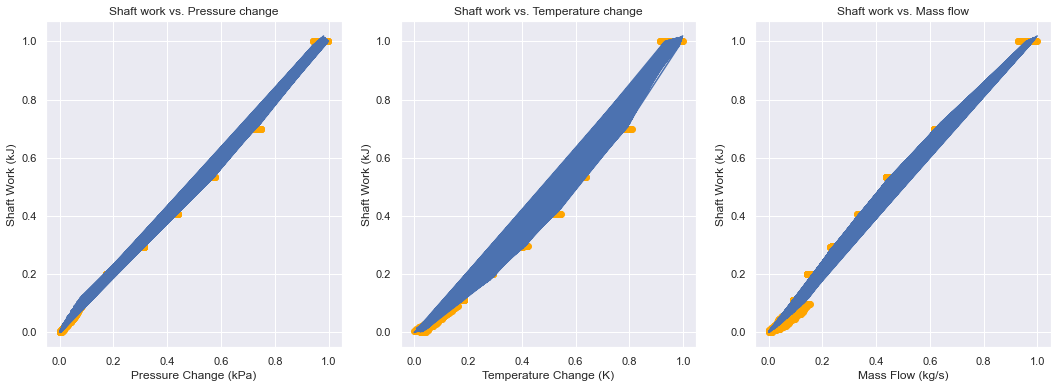

In [8]:
fig, ax = plt.subplots(1, 3, figsize = (18,6))

ax[0].scatter(x_test['P_delta'], y_test, c = 'orange')
ax[0].plot(x_test['P_delta'], y_pred, c = 'b')
ax[0].set_title('Shaft work vs. Pressure change')
ax[0].set_xlabel('Pressure Change (kPa)')
ax[0].set_ylabel('Shaft Work (kJ)')

ax[1].scatter(x_test['T_delta'], y_test, c = 'orange')
ax[1].plot(x_test['T_delta'], y_pred, c = 'b')
ax[1].set_title('Shaft work vs. Temperature change')
ax[1].set_xlabel('Temperature Change (K)')
ax[1].set_ylabel('Shaft Work (kJ)')

ax[2].scatter(x_test['mass_flow'], y_test, c = 'orange')
ax[2].plot(x_test['mass_flow'], y_pred, c = 'b')
ax[2].set_title('Shaft work vs. Mass flow')
ax[2].set_xlabel('Mass Flow (kg/s)')
ax[2].set_ylabel('Shaft Work (kJ)');